In [1]:
import openmc
import numpy as np

In [2]:
# UO2 fuel kernel
uo2 = openmc.Material(name='UO2', temperature=900)
uo2.add_element('U', 1.0, enrichment=5.0)  # 5% enriched, adjust as needed
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.97)

# SiC coating
sic = openmc.Material(name='SiC', temperature=900)
sic.add_element('Si', 1.0)
sic.add_element('C', 1.0)
sic.set_density('g/cm3', 3.21)

# Lead-Lithium (Pb83at%-Li17at%)
pbli = openmc.Material(name='PbLi', temperature=900)
pbli.add_element('Pb', 0.83)
pbli.add_element('Li', 0.17, percent_type='ao', enrichment_target='Li6', enrichment_type='wo', enrichment=90.0)
pbli.set_density('g/cm3', 9.5) 

materials = openmc.Materials([uo2, sic, pbli])
materials.cross_sections = '/mnt/c/OpenMC/data/endfb-viii.0-hdf5/cross_sections.xml'
# materials.export_to_xml()

In [3]:
# UO2 kernel sphere (radius = 0.02 cm)
kernel_outer = openmc.Sphere(r=0.04)

# SiC coating outer surface (radius = 0.02 + 0.01 = 0.03 cm)
sic_outer = openmc.Sphere(r=0.05)

# Reflective cube boundaries (10 cm on each side for computational domain)
# Using reflective boundary conditions
cube_size = 0.05  # cm

# cube_size = 0.05  # cm for BISO particle to be 50% vol # = ((4/3(pi)(0.05)^3)/0.5)^(1/3)/2 = 0.05077456487
# cube_size = 0.187 # cm for BISO particle to be 1% vol # = ((4/3(pi)(0.05)^3)/0.01)^(1/3)/2 = 0.18705509634

x_min = openmc.XPlane(-cube_size/2, boundary_type='reflective')
x_max = openmc.XPlane(cube_size/2, boundary_type='reflective')
y_min = openmc.YPlane(-cube_size/2, boundary_type='reflective')
y_max = openmc.YPlane(cube_size/2, boundary_type='reflective')
z_min = openmc.ZPlane(-cube_size/2, boundary_type='reflective')
z_max = openmc.ZPlane(cube_size/2, boundary_type='reflective')

# Define cells
# UO2 kernel
cell_kernel = openmc.Cell(name='UO2_kernel')
cell_kernel.fill = uo2
cell_kernel.region = -kernel_outer

# SiC coating
cell_sic = openmc.Cell(name='SiC_coating')
cell_sic.fill = sic
cell_sic.region = +kernel_outer & -sic_outer

# Lead-Lithium matrix
cell_pbli = openmc.Cell(name='PbLi_matrix')
cell_pbli.fill = pbli
cell_pbli.region = +sic_outer & +x_min & -x_max & +y_min & -y_max & +z_min & -z_max

# Create universe and geometry
root_universe = openmc.Universe(cells=[cell_kernel, cell_sic, cell_pbli])
geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

In [4]:
settings = openmc.Settings()

"""Source: 14 MeV from -x face toward +x"""
eps = 1.0e-6
cube_half = cube_size / 2
space = openmc.stats.Box(
        lower_left=(-cube_half + eps, -cube_half, -cube_half),
        upper_right=(-cube_half + 2*eps,  cube_half,  cube_half),
        only_fissionable=False
    )
angle = openmc.stats.Monodirectional(reference_uvw=(1.0, 0.0, 0.0))
energy = openmc.stats.Discrete([14.0e6], [1.0])
src = openmc.Source(space=space, angle=angle, energy=energy)

"""Settings"""
settings = openmc.Settings()
settings.run_mode = "fixed source"
settings.batches = 50
settings.particles = int(1e4)
settings.sources = [src]

/home/patri/.local/lib/python3.12/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [5]:
"""Tallies: region split + 1D centerline mesh"""
t_region = openmc.Tally(name="flux_by_region")
t_region.filters = [openmc.CellFilter([cell_kernel, cell_sic, cell_pbli])]
t_region.scores = ["flux"]

# 1D mesh along x, narrow pencil in y,z around the center
yz = 0.0125
mesh = openmc.RegularMesh()
mesh.dimension = (500, 1, 1) # 200 = number of bins in x axis
mesh.lower_left = (-cube_half, -yz, -yz)
mesh.upper_right = ( cube_half,  yz,  yz)

mesh_filter = openmc.MeshFilter(mesh)
t_mesh = openmc.Tally(name="flux_centerline_x")
t_mesh.filters = [mesh_filter]
t_mesh.scores = ["flux"]

tallies = openmc.Tallies([t_region, t_mesh])

In [6]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_xml()
model.run() 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

RuntimeError: Maximum number of lost particles has been reached.

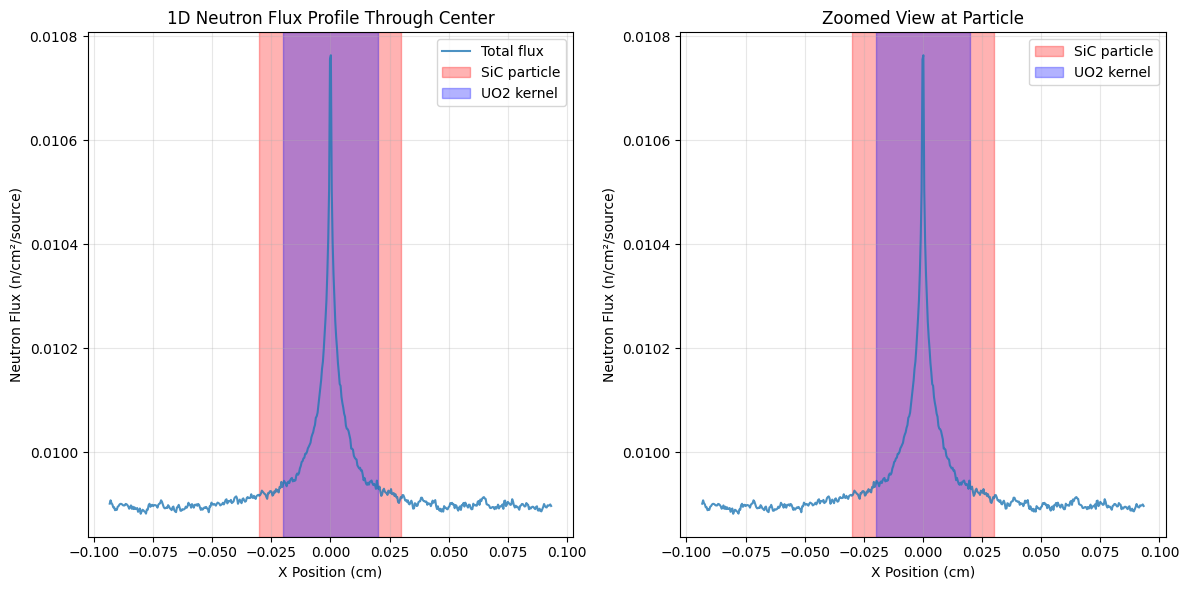

In [41]:
import matplotlib.pyplot as plt

with openmc.StatePoint('statepoint.50.h5') as sp:

    # Get 1D flux tally
    tally_1d = sp.get_tally(name='flux_centerline_x')

    # Extract mesh and reshape
    mesh = tally_1d.find_filter(openmc.MeshFilter).mesh
    flux_mean = tally_1d.mean.ravel()
    flux_std = tally_1d.std_dev.ravel()

    # Get x positions (centers of mesh bins)
    x_min, x_max = mesh.lower_left[0], mesh.upper_right[0]
    nx = mesh.dimension[0]
    x_positions = np.linspace(x_min, x_max, nx + 1)
    x_centers = (x_positions[:-1] + x_positions[1:]) / 2

    # Create plot of 1D flux profile
    plt.figure(figsize=(12, 6))

    # Main plot (no error bars, no dot markers)
    plt.subplot(1, 2, 1)
    plt.plot(x_centers, flux_mean, '-', linewidth=1.5, alpha=0.8, label='Total flux')
    plt.axvspan(-0.03, 0.03, alpha=0.3, color='red', label='SiC particle')
    plt.axvspan(-0.02, 0.02, alpha=0.3, color='blue', label='UO2 kernel')
    plt.xlabel('X Position (cm)')
    plt.ylabel('Neutron Flux (n/cm²/source)')
    plt.title('1D Neutron Flux Profile Through Center')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Zoomed plot around particle
    plt.subplot(1, 2, 2)
    mask = (x_centers >= -0.2) & (x_centers <= 0.2)
    plt.plot(x_centers[mask], flux_mean[mask], '-', linewidth=1.5, alpha=0.8)
    plt.axvspan(-0.03, 0.03, alpha=0.3, color='red', label='SiC particle')
    plt.axvspan(-0.02, 0.02, alpha=0.3, color='blue', label='UO2 kernel')
    plt.xlabel('X Position (cm)')
    plt.ylabel('Neutron Flux (n/cm²/source)')
    plt.title('Zoomed View at Particle')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('flux_profile_1d.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Save data to CSV for further analysis
    np.savetxt(
        'flux_profile_1d.csv',
        np.column_stack([x_centers, flux_mean, flux_std]),
        delimiter=',',
        header='x_position(cm),flux_mean,flux_std',
        comments=''
    )
